In [20]:
from collections import defaultdict
from datetime import datetime, date
import math
import os
import warnings

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

from qaoa_solver import QAOASolver
from utils import int_to_binary_str, compute_solution, compute_fidelity


pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
DEFAULT_ANGLE = 1.047

experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        #result['experiment'] = experiment
        result['date'] = result_date
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)
experiment_results['gamma_0'] = experiment_results['gamma_0'].round(3)
experiment_results['beta_0'] = experiment_results['beta_0'].round(3)
experiment_results['angle_interpolation'] = experiment_results['commit_date'] >= datetime(2025,6,10)

In [3]:
dup_subset = ['experiment', 'layers', 'optimizer', 'gamma_0', 'beta_0', 'cost', 'angle_interpolation']

dups = experiment_results[dup_subset]
dups = dups.groupby(dups.columns.tolist(),as_index=False).size().sort_values('size', ascending=False)
dups = dups[dups['size']>1]

if not dups.empty:
    print('Duplicates found!')
    display(dups.head())

experiment_results = experiment_results.drop_duplicates(subset=dup_subset).reset_index(drop=True)

Duplicates found!


,experiment,layers,optimizer,gamma_0,beta_0,cost,angle_interpolation,size
4778,N481_standard,15,BFGS,1.047,1.047,4.154907e+06,False,3
4796,N481_standard,16,BFGS,1.047,1.047,4.294798e+06,False,3
4526,N481_standard,1,BFGS,1.047,1.047,4.632930e+06,False,3
4545,N481_standard,2,BFGS,1.047,1.047,4.303232e+06,False,3
4562,N481_standard,3,BFGS,1.047,1.047,3.301380e+06,False,3


In [4]:
plot_colors = [
    #[Dark ,    light]
    ["black",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#cc4c02", "#fe9929"],  # Orange
    ["#91003f", "#c994c7"],  # Purple
    ["#8c510a", "#d8b365"],  # Brown
    ["#0868ac", "#43a2ca"],  # Cian
    ["#b8860b", "#ffd700"],  # Golden
]

In [5]:
Ns = sorted(experiment_results.N.unique())
optimizers = sorted(experiment_results.optimizer.unique())
setups = sorted(experiment_results.setup.unique(), reverse=True)

In [6]:
group_cols = ['N', 'setup', 'optimizer', 'layers', 'extended_qaoa']

experiment_results_agg = (
    experiment_results
        .groupby(group_cols)
        .agg({
            'num_qubits': 'first',
            'N': 'count',
            'cost': ['mean', 'median', 'std', 'max', 'min'],
            'fidelity': ['mean', 'median', 'std', 'max', 'min'],
            'optimizer_time': ['mean', 'median', 'std', 'max', 'min'],
            'state_populations': lambda x: np.sum(x.tolist(), axis=0).tolist()
        })
    )

experiment_results_agg.columns = ['_'.join(map(str, col)) for col in experiment_results_agg.columns.to_flat_index()]
experiment_results_agg = experiment_results_agg.rename(columns={'num_qubits_first': 'num_qubits'})
experiment_results_agg = experiment_results_agg.rename(columns={'state_populations_<lambda>': 'populations'})
experiment_results_agg = experiment_results_agg.rename(columns={'N_count': 'count'})

experiment_results_agg['populations_mean'] = experiment_results_agg.apply(lambda row: np.array(row['populations'])/row['count'], axis=1)
experiment_results_agg = experiment_results_agg.drop(columns='populations')

# Get the id where cost is minimum for each group
idx_min = experiment_results.groupby(group_cols)['cost'].idxmin()
best_populations = experiment_results.loc[idx_min, group_cols + ['state_populations']]
best_populations = best_populations.rename(columns={'state_populations': 'best_populations'})

# Merge the best_id into the aggregated DataFrame
experiment_results_agg = experiment_results_agg.merge(best_populations, on=group_cols, how='left')


experiment_results_agg = experiment_results_agg.sort_values(['N', 'optimizer', 'setup', 'layers', 'extended_qaoa'])
experiment_results_agg = experiment_results_agg.reset_index(drop=True)

# experiment_results_agg['infidelity_mean'] = 1 - experiment_results_agg['fidelity_mean']
# experiment_results_agg['infidelity_median'] = 1 - experiment_results_agg['fidelity_median']
# experiment_results_agg['infidelity_min'] = 1 - experiment_results_agg['fidelity_max']
# experiment_results_agg['infidelity_max'] = 1 - experiment_results_agg['fidelity_min']

# experiments_df = pd.merge(experiment_configs, experiment_results_agg, how='inner', on='experiment')

# if (experiments_df['num_gates_std'] != 0).any():
#     print('Warning: There are experiments with inconsistent number of gates')

## Comparison between optimizers

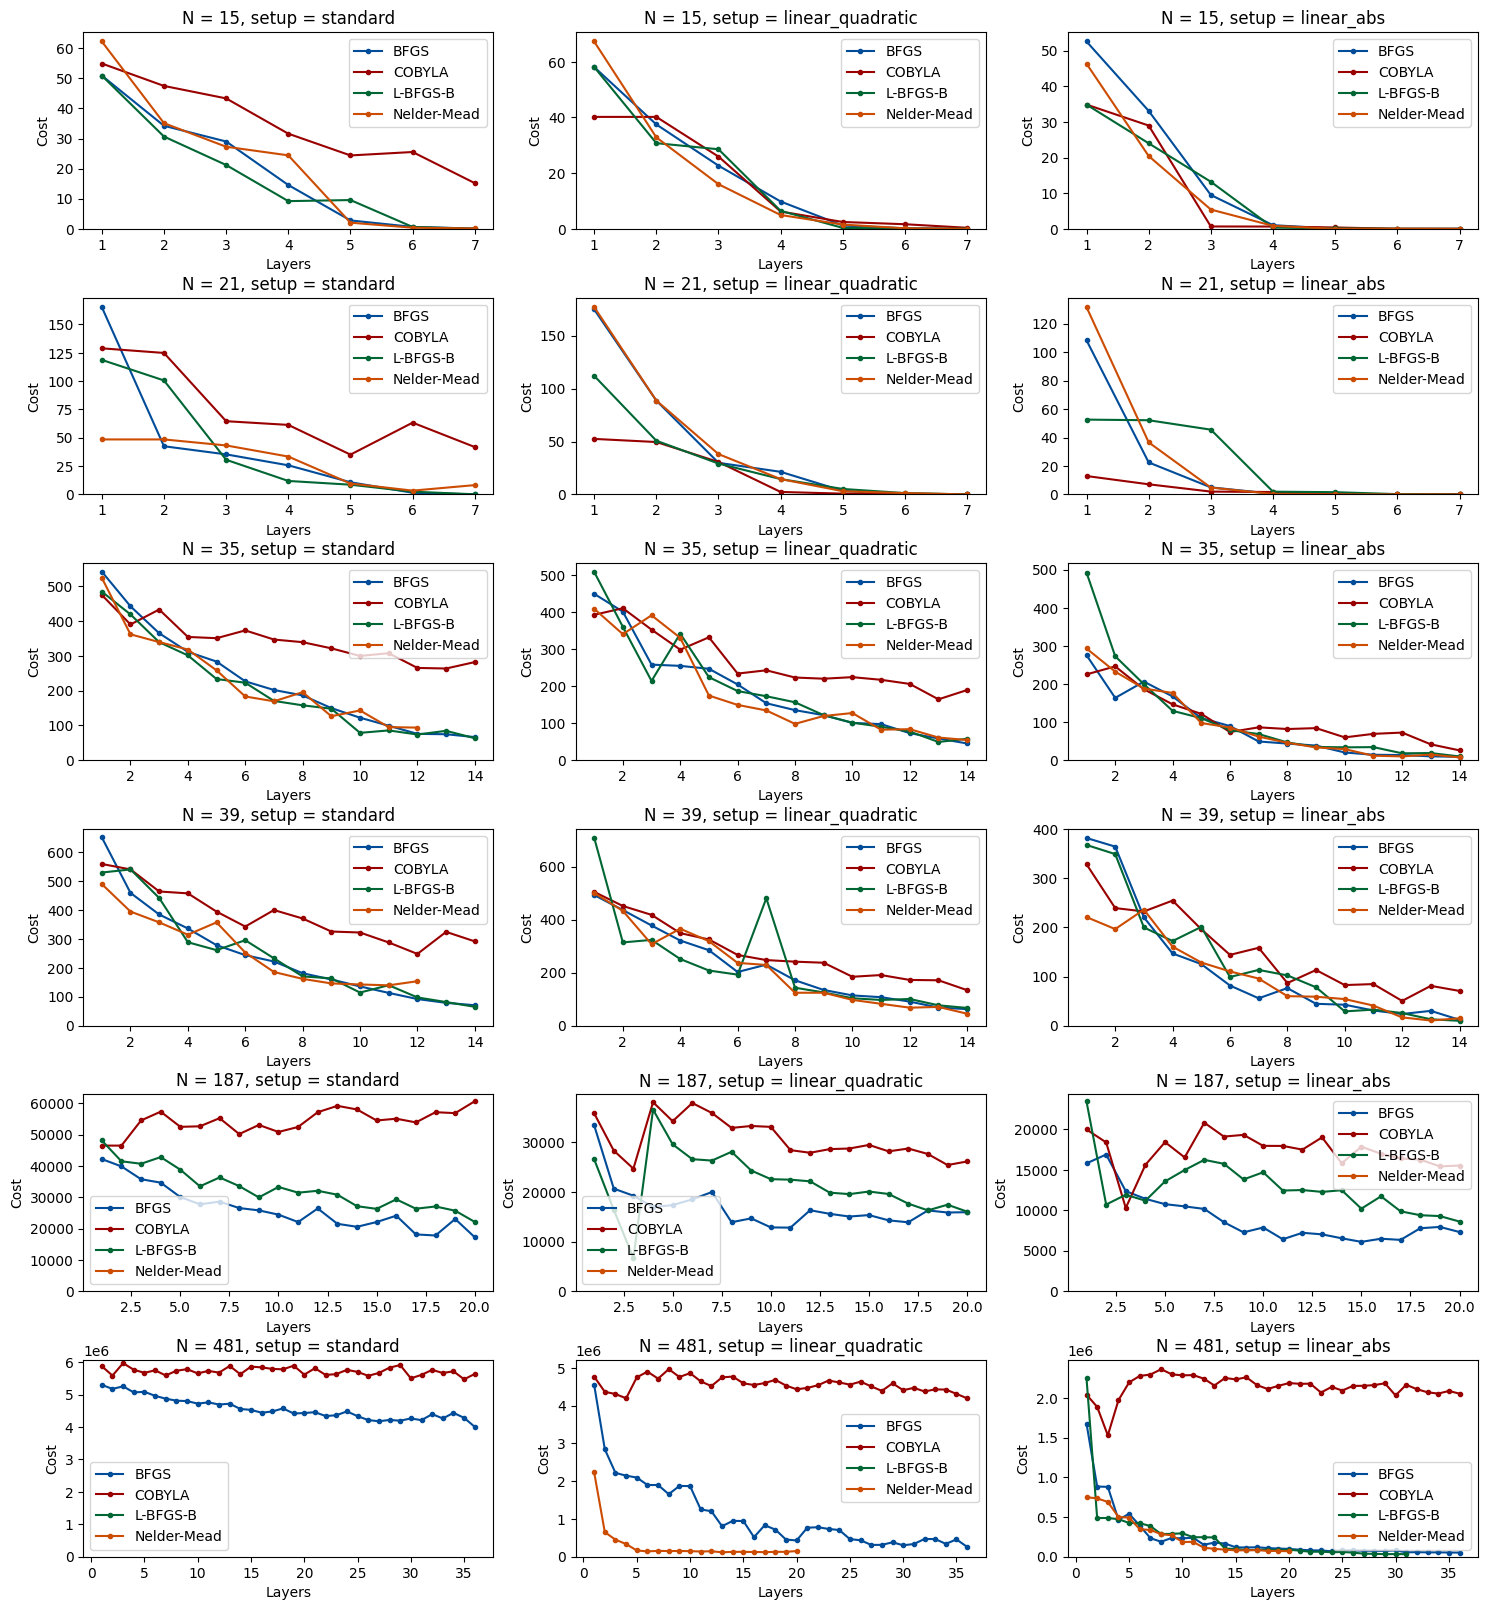

In [7]:
extended_qaoa = False

fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.extended_qaoa == extended_qaoa)]
    for k, setup in enumerate(setups):
        for j, optimizer in enumerate(optimizers):
            df = df_N[(df_N.setup == setup) & (df_N.optimizer == optimizer)].copy()
            if setup == 'linear_abs':
                df['cost_median'] = np.power(df['cost_median'], 2)
            axs[i,k].plot('layers', 'cost_median', data=df, marker='.', color=plot_colors[j+1][0], label=optimizer)

        axs[i,k].set_ylabel('Cost')
        axs[i,k].set_title(f'N = {N}, setup = {setup}')
        axs[i,k].set_xlabel('Layers');
        axs[i,k].set_ylim(0);

        axs[i,k].legend(loc='best');

fig_name = f'plots/methods_comparison.pdf'
plt.savefig(fig_name, bbox_inches='tight')


We use BFGS since it is the fastest optimizer for this dimensionalities

## Comparison between setups for BFGS

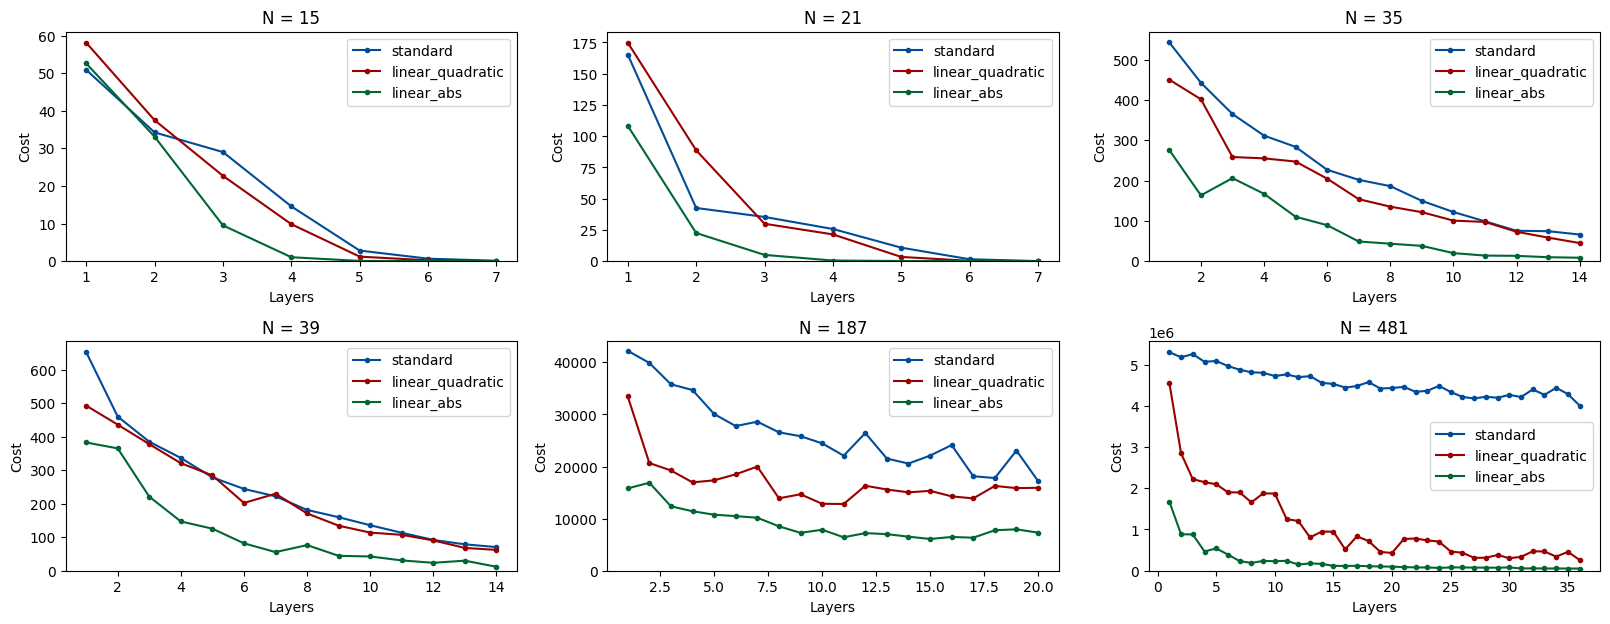

In [8]:
extended_qaoa = False

fig, axs = plt.subplots(math.ceil(len(Ns)/3), 3, figsize=(3.3*len(Ns), 7))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.optimizer == 'BFGS') & (experiment_results_agg.extended_qaoa == extended_qaoa)]
    for j, setup in enumerate(setups):
        df = df_N[df_N.setup == setup].copy()
        if setup == 'linear_abs':
            df['cost_median'] = np.power(df['cost_median'], 2)
        axs[i].plot('layers', 'cost_median', data=df, marker='.', color=plot_colors[j+1][0], label=setup)

    axs[i].set_ylabel('Cost')
    axs[i].set_title(f'N = {N}')
    axs[i].set_xlabel('Layers');
    axs[i].set_ylim(0);

    axs[i].legend(loc='best');

fig_name = f'plots/setups_comparison.pdf'
plt.savefig(fig_name, bbox_inches='tight')


## Comparison between traditional vs extended QAOA

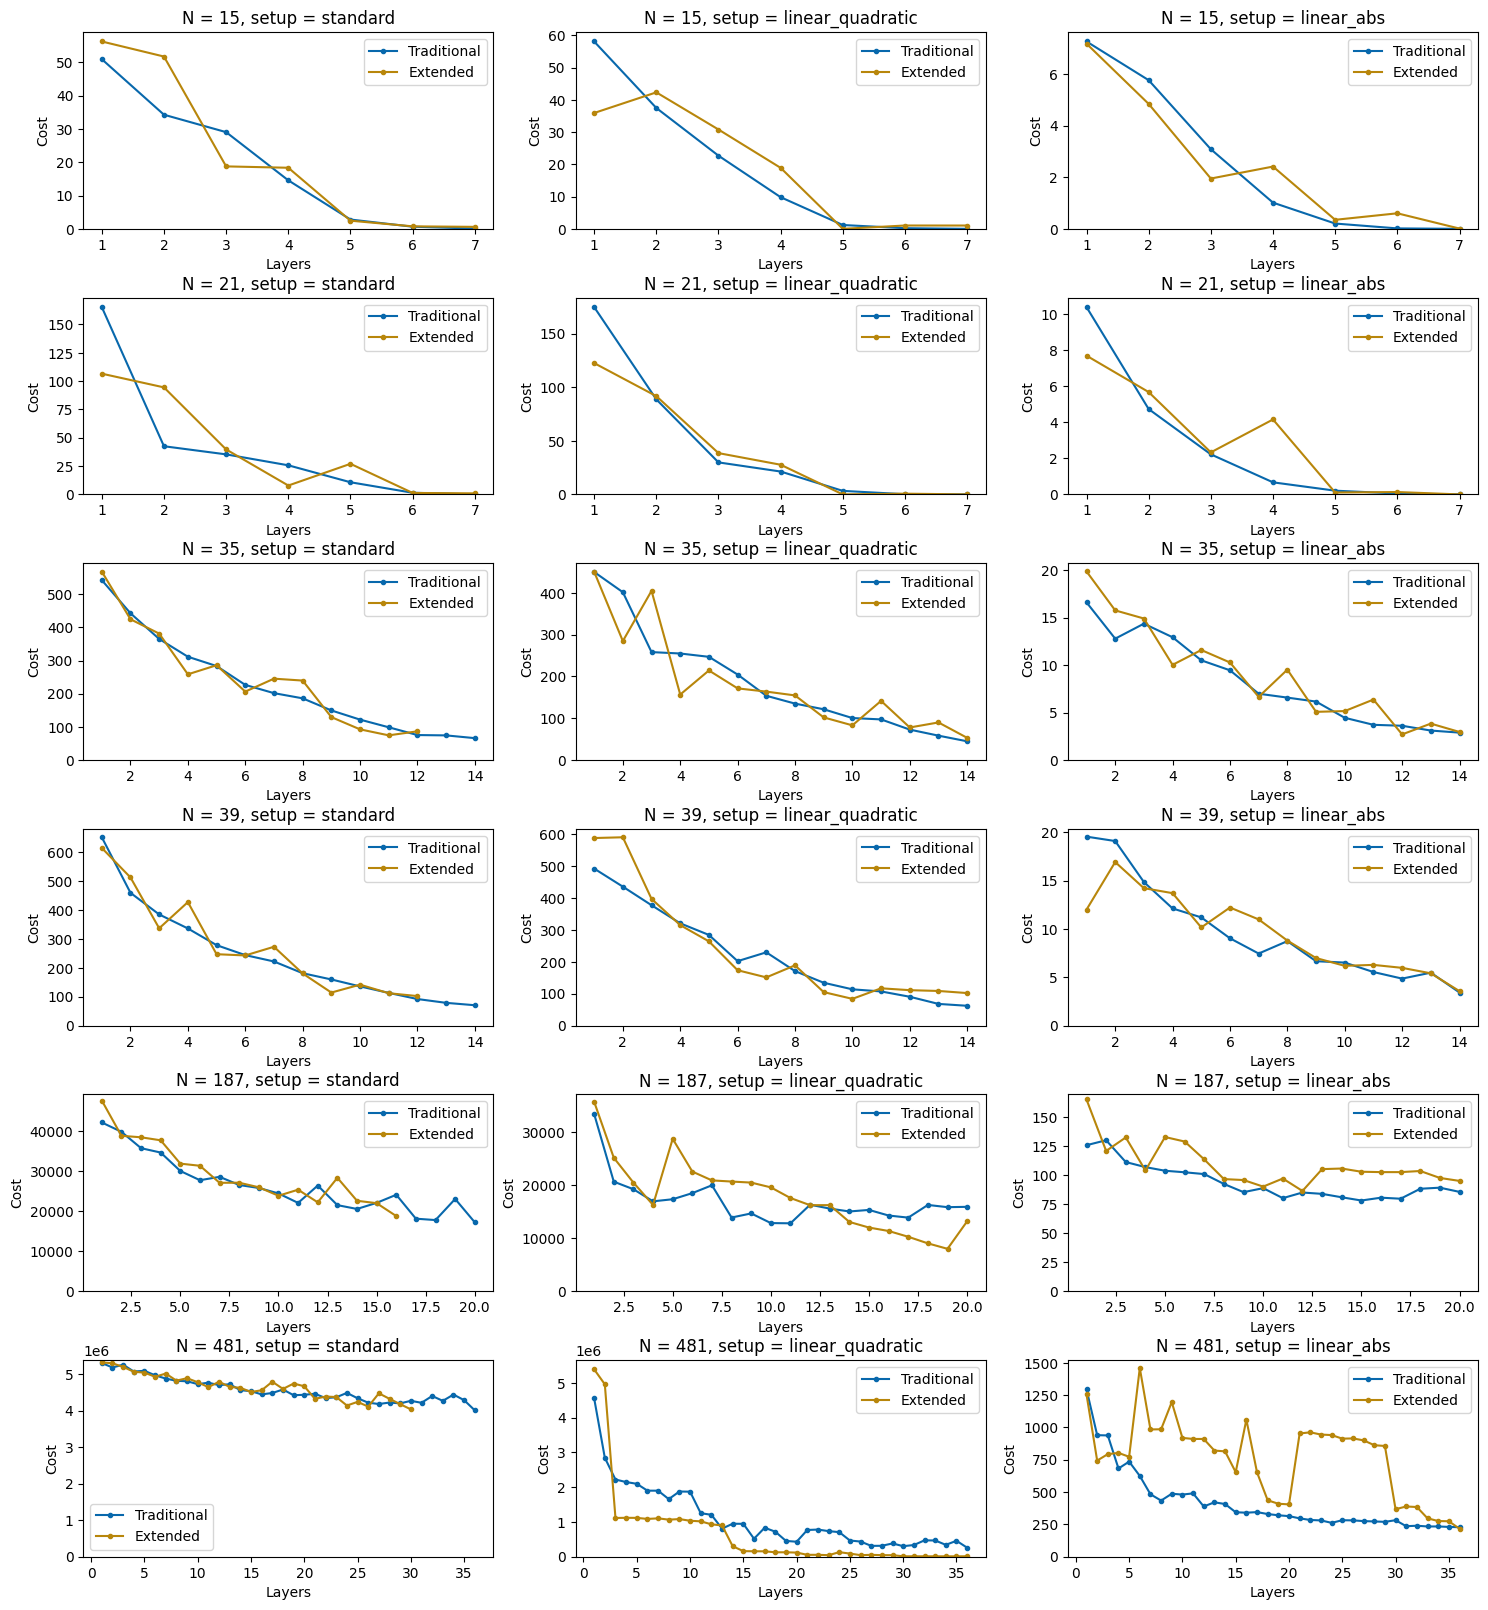

In [9]:
fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.optimizer == 'BFGS')]

    for j, setup in enumerate(setups):

        df = df_N[df_N['setup']==setup]

        axs[i,j].plot('layers', 'cost_median', data=df[df['extended_qaoa']==False], marker='.', color=plot_colors[7][0], label='Traditional')
        axs[i,j].plot('layers', 'cost_median', data=df[df['extended_qaoa']==True], marker='.', color=plot_colors[8][0], label='Extended')

        axs[i,j].set_ylabel('Cost')
        axs[i,j].set_title(f'N = {N}, setup = {setup}')
        axs[i,j].set_xlabel('Layers');
        axs[i,j].set_ylim(0);

        axs[i,j].legend(loc='best');


## Average Populations

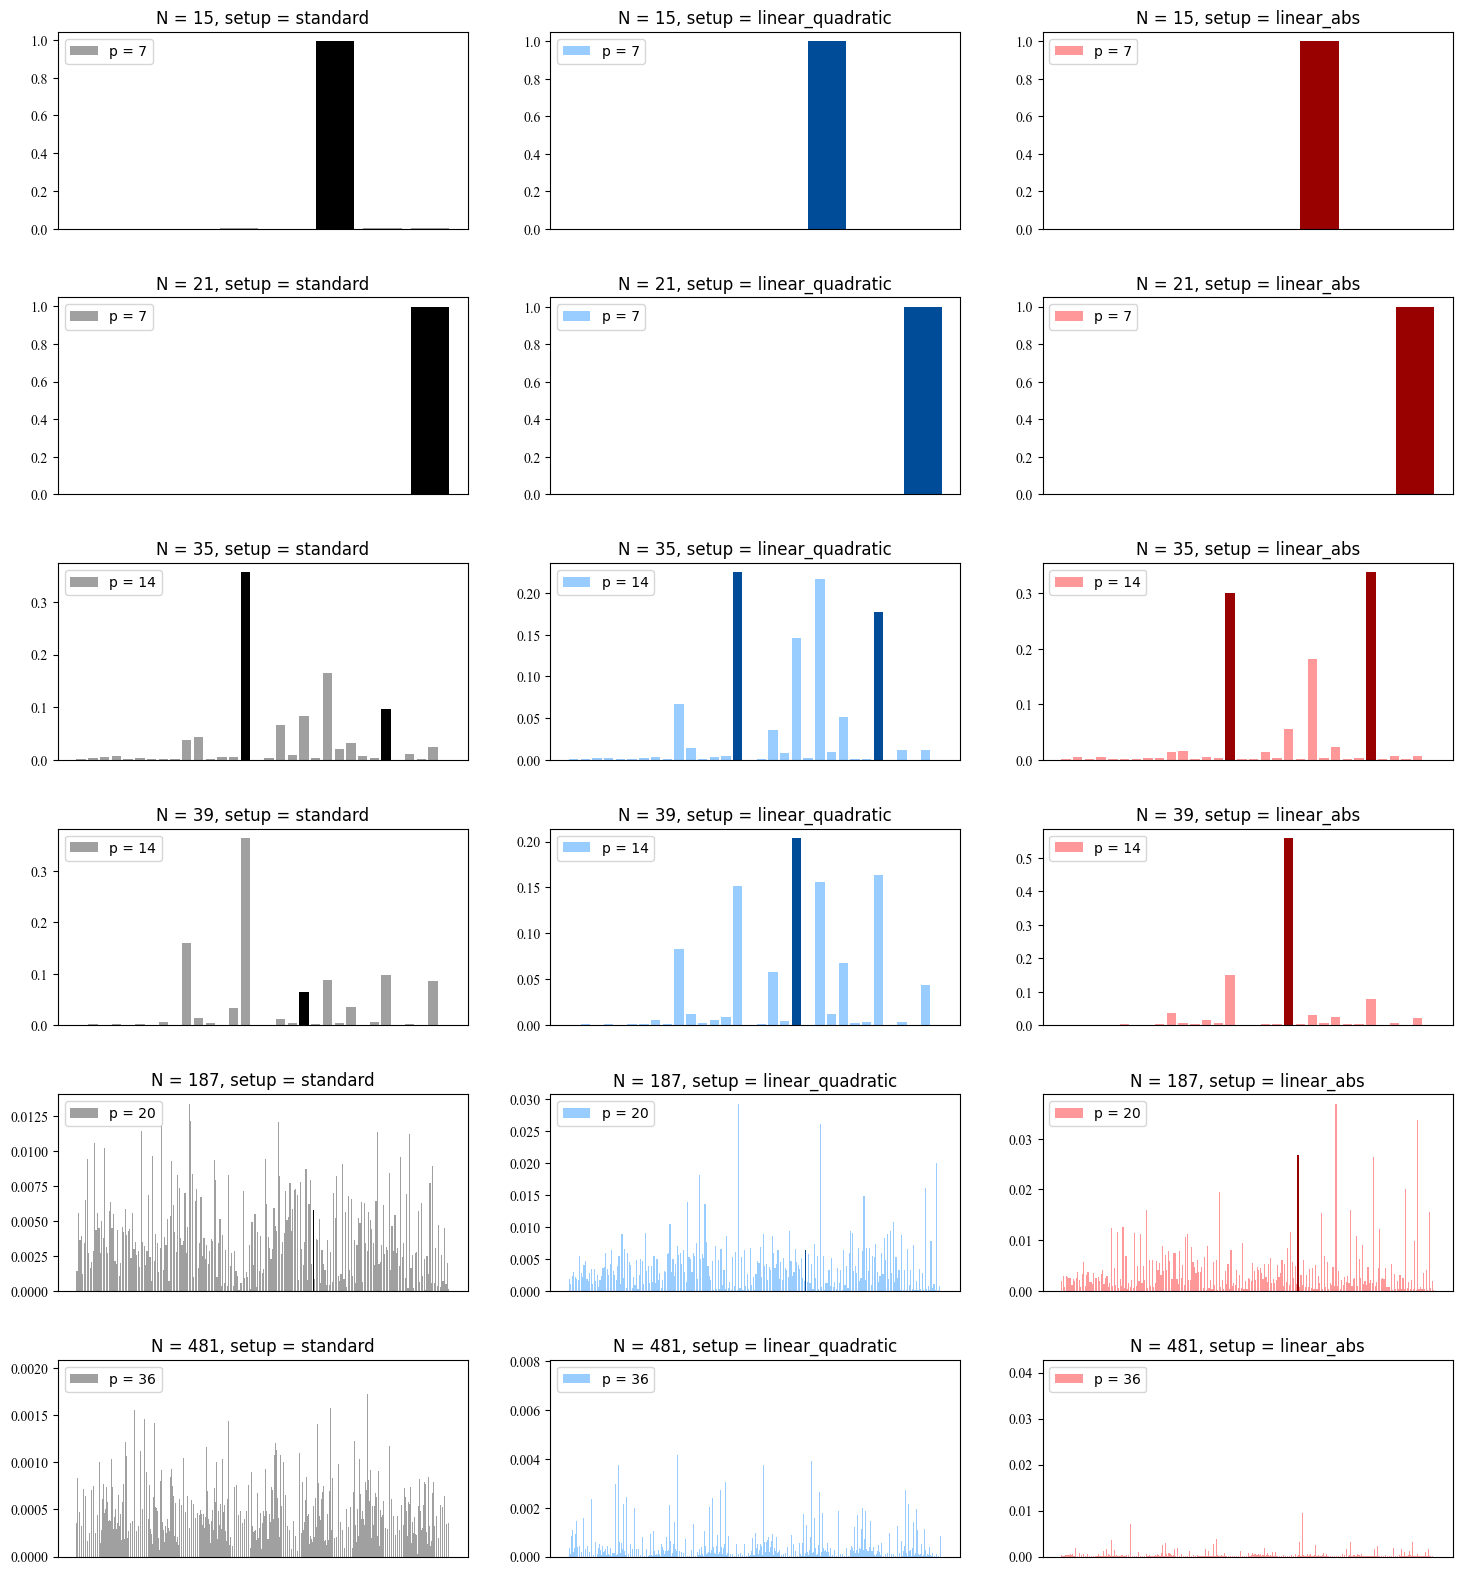

In [10]:
fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.optimizer == 'BFGS')
                                  & (experiment_results_agg.extended_qaoa == False)].reset_index(drop=True)
    num_qubits = df_N.loc[0, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    max_layers = df_N['layers'].max()

    for j, setup in enumerate(setups):

        df_N_setup = df_N[(df_N['setup']==setup)]
        max_layers = df_N_setup['layers'].max()
        df =  df_N_setup[df_N_setup['layers']==max_layers].reset_index(drop=True).loc[0, 'populations_mean']

        bar_colors = [plot_colors[j][0] if c in solutions else plot_colors[j][1] for c in x_hist]

        axs[i][j].bar(x_hist, df, label=f'p = {max_layers}', color=bar_colors)
        axs[i][j].set_ylim(0)

        labels = (axs[i][j].get_xticklabels() + axs[i][j].get_yticklabels())

        for label in labels:
            label.set_fontname('Times New Roman')

        axs[i][j].legend(loc='upper left')
        axs[i][j].set_xticks(range(2**num_qubits), "")
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].set_title(f'N = {N}, setup = {setup}')

fig_name = f'plots/analysis_populations.pdf'
plt.savefig(fig_name, bbox_inches='tight')

## Angle interpolation (default initial angles)

In [11]:
experiment_results_def = experiment_results[(experiment_results['gamma_0']==DEFAULT_ANGLE) & (experiment_results['beta_0']==DEFAULT_ANGLE)]

group_cols = ['N', 'setup', 'optimizer', 'layers', 'extended_qaoa', 'angle_interpolation']

experiment_results_agg_def = (
    experiment_results_def
        .groupby(group_cols)
        .agg({
            'num_qubits': 'first',
            'N': 'count',
            'cost': ['mean', 'median', 'std', 'max', 'min'],
            'fidelity': ['mean', 'median', 'std', 'max', 'min'],
            'optimizer_time': ['mean', 'median', 'std', 'max', 'min'],
            'state_populations': lambda x: np.sum(x.tolist(), axis=0).tolist()
        })
    )

experiment_results_agg_def.columns = ['_'.join(map(str, col)) for col in experiment_results_agg_def.columns.to_flat_index()]
experiment_results_agg_def = experiment_results_agg_def.rename(columns={'num_qubits_first': 'num_qubits'})
experiment_results_agg_def = experiment_results_agg_def.rename(columns={'state_populations_<lambda>': 'populations'})
experiment_results_agg_def = experiment_results_agg_def.rename(columns={'N_count': 'count'})

experiment_results_agg_def['populations_mean'] = experiment_results_agg_def.apply(lambda row: np.array(row['populations'])/row['count'], axis=1)
experiment_results_agg_def = experiment_results_agg_def.drop(columns='populations')

# Get the id where cost is minimum for each group
idx_min = experiment_results_def.groupby(group_cols)['cost'].idxmin()
best_populations = experiment_results_def.loc[idx_min, group_cols + ['state_populations']]
best_populations = best_populations.rename(columns={'state_populations': 'best_populations'})

# Merge the best_id into the aggregated DataFrame
experiment_results_agg_def = experiment_results_agg_def.merge(best_populations, on=group_cols, how='left')


experiment_results_agg_def = experiment_results_agg_def.sort_values(['N', 'optimizer', 'setup', 'layers', 'extended_qaoa'])
experiment_results_agg_def = experiment_results_agg_def.reset_index(drop=True)

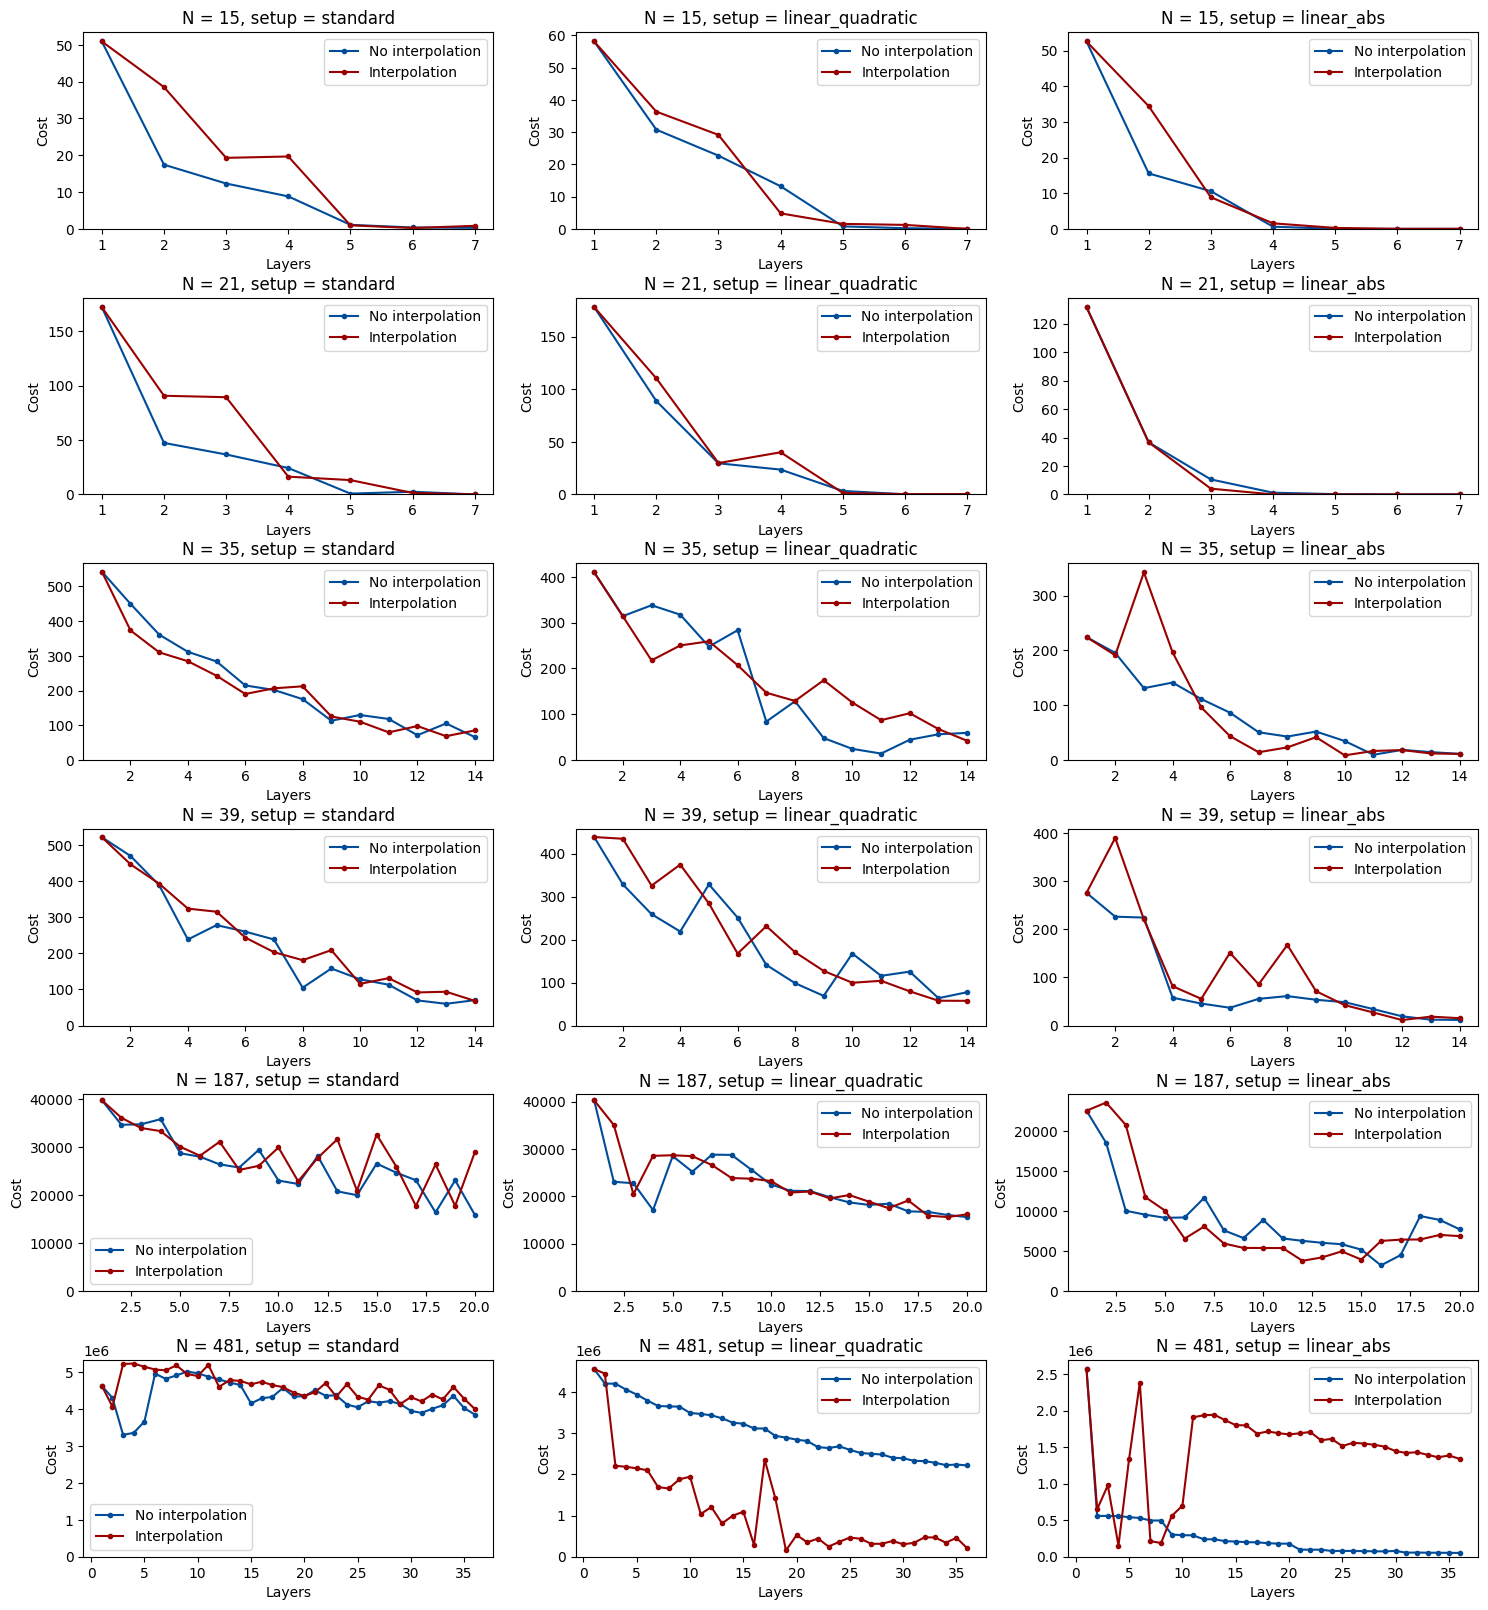

In [12]:
extended_qaoa = False
optimizer = 'BFGS'

fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results_agg_def[
        (experiment_results_agg_def.N == N)
        & (experiment_results_agg_def.extended_qaoa == extended_qaoa)
        & (experiment_results_agg_def.optimizer == optimizer)]
    for k, setup in enumerate(setups):
        for j, interpolation in enumerate([False, True]):
            label = 'Interpolation' if interpolation else 'No interpolation'
            df = df_N[(df_N.setup == setup) & (df_N.angle_interpolation == interpolation)].copy()
            if setup == 'linear_abs':
                df['cost_median'] = np.power(df['cost_median'], 2)
            axs[i,k].plot('layers', 'cost_median', data=df, marker='.', color=plot_colors[j+1][0], label=label)

        axs[i,k].set_ylabel('Cost')
        axs[i,k].set_title(f'N = {N}, setup = {setup}')
        axs[i,k].set_xlabel('Layers');
        axs[i,k].set_ylim(0);

        axs[i,k].legend(loc='best');

fig_name = f'plots/interpolation.pdf'
plt.savefig(fig_name, bbox_inches='tight')

## Best results

### By cost

In [13]:
group_cols = ['N', 'setup']

df = experiment_results[experiment_results['extended_qaoa']==False]

# Get the id where cost is minimum for each group
idx_min = df.groupby(group_cols)['cost'].idxmin()
best_results = df.loc[idx_min,]

best_results = best_results[['N', 'setup', 'optimizer', 'layers', 'initial_gammas', 'initial_betas', 'state_populations', 'angle_interpolation', 'fidelity', 'cost', 'num_qubits']].reset_index(drop=True)

best_results

,N,setup,optimizer,layers,initial_gammas,initial_betas,state_populations,angle_interpolation,fidelity,cost,num_qubits
0,15,linear_abs,BFGS,7,"[0.7988747656079751, 0.925286992294134, 0.6512...","[3.8640885829926632, 2.75839819925731, 2.08092...","[9.719198196073167e-17, 1.4529222086654011e-15...",False,1.000000,1.537686e-13,3
1,15,linear_quadratic,BFGS,7,"[3.404583800611499, 2.220259241825644, 1.49550...","[0.440997839890563, 3.722278594310011, 1.57781...","[2.7829260818561858e-18, 5.263673525677686e-18...",False,1.000000,3.298375e-15,3
2,15,standard,BFGS,7,"[2.376055458816754, 2.143439609205466, 1.05031...","[1.693803785641976, 1.9442125560703172, 2.7876...","[4.4827516443404136e-21, 4.000932309956957e-22...",False,1.000000,8.830261e-18,3
3,21,linear_abs,BFGS,7,"[-0.147376064053743, -0.28329361202787, -0.518...","[5.013738216825036, -0.49260749257048303, 0.46...","[2.719858712335958e-17, 6.733855978482246e-17,...",False,1.000000,6.646211e-14,3
4,21,linear_quadratic,BFGS,7,"[4.538081586314768, 1.520205933221055, 0.79876...","[0.07915771654968701, 4.39318843810523, 2.3450...","[5.7820958816299566e-18, 4.9166154889447876e-1...",False,1.000000,1.265052e-14,3
5,21,standard,BFGS,7,"[3.046549333456884, 1.3340487762418771, 1.5754...","[4.5400900851767485, -2.122249922655497, -0.79...","[8.165844205515257e-23, 3.1380503510563255e-22...",False,1.000000,3.022534e-19,3
6,35,linear_abs,BFGS,14,"[5.513069155290911, -0.031377280371194, -0.571...","[3.195274601631065, 2.375683249153609, 3.20058...","[0.0011308628809194431, 0.00032291891197263315...",False,0.988316,2.263945e-01,5
7,35,linear_quadratic,BFGS,11,"[0.760952996755884, 2.169912156739247, 1.76043...","[1.080298343518739, -0.274990891558266, 0.8050...","[0.00015129444705153366, 0.0007335764528869246...",False,0.942373,1.406253e+01,5
8,35,standard,BFGS,12,"[2.762760633159763, 1.0139161161472101, 0.2077...","[2.396615794563155, 0.379283464053061, 0.98434...","[0.0007826787249892628, 0.0017999503586928938,...",False,0.479391,4.883698e+01,5
9,39,linear_abs,L-BFGS-B,14,"[1.361386486246998, 1.9809046596362712, 6.2263...","[5.9452388374643945, 5.567446005950853, 2.2516...","[6.63658942851993e-05, 7.022040044312246e-05, ...",False,0.948586,6.797136e-01,5


### By fidelity

In [14]:
idx_min = df.groupby(group_cols)['fidelity'].idxmax()
best_results = df.loc[idx_min,]

best_results = best_results[['N', 'setup', 'optimizer', 'layers', 'initial_gammas', 'initial_betas', 'state_populations', 'angle_interpolation', 'fidelity', 'cost', 'num_qubits']].reset_index(drop=True)

best_results

,N,setup,optimizer,layers,initial_gammas,initial_betas,state_populations,angle_interpolation,fidelity,cost,num_qubits
0,15,linear_abs,BFGS,7,"[0.7988747656079751, 0.925286992294134, 0.6512...","[3.8640885829926632, 2.75839819925731, 2.08092...","[9.719198196073167e-17, 1.4529222086654011e-15...",False,1.000000,1.537686e-13,3
1,15,linear_quadratic,BFGS,7,"[0.13088231176470602, 1.280506954533214, 2.446...","[2.186708883115892, 1.320500096275268, -0.6311...","[1.9757202281653018e-17, 3.614097077153427e-18...",False,1.000000,1.674431e-14,3
2,15,standard,BFGS,7,"[6.365742867129288, 1.293839939379417, -0.0736...","[1.368799914500254, 0.48813426477450705, 1.356...","[1.2893253233689269e-21, 4.466274830411287e-20...",False,1.000000,9.843531e-18,3
3,21,linear_abs,BFGS,7,"[2.048414683731871, 1.185894208702452, 1.18892...","[0.768780575447336, 1.705101122082425, 1.23561...","[1.3804655592983821e-15, 2.4225588053872235e-1...",False,1.000000,6.804112e-14,3
4,21,linear_quadratic,BFGS,7,"[1.396488943071431, 1.520205923012603, 0.79876...","[0.079157714711464, 4.393188436226508, 2.34503...","[1.2792230448492384e-17, 1.9582374115866097e-1...",False,1.000000,2.103862e-14,3
5,21,standard,BFGS,7,"[3.046549333456884, 1.3340487762418771, 1.5754...","[4.5400900851767485, -2.122249922655497, -0.79...","[8.165844205515257e-23, 3.1380503510563255e-22...",False,1.000000,3.022534e-19,3
6,35,linear_abs,BFGS,13,"[5.512588916529634, 0.10201085339530701, -0.57...","[2.4927049325842843, 3.319578407166412, 3.0443...","[0.0014677062104428474, 0.00012450958956794502...",False,0.988661,2.552754e-01,5
7,35,linear_quadratic,BFGS,11,"[0.760952996755884, 2.169912156739247, 1.76043...","[1.080298343518739, -0.274990891558266, 0.8050...","[0.00015129444705153366, 0.0007335764528869246...",False,0.942373,1.406253e+01,5
8,35,standard,BFGS,14,"[1.750660491140038, 1.43937989783023, 0.763061...","[0.574194487194797, 0.33136104573287, -0.59599...","[0.0009099952564454205, 0.004593977470357765, ...",True,0.657452,8.509635e+01,5
9,39,linear_abs,L-BFGS-B,14,"[1.361386486246998, 1.9809046596362712, 6.2263...","[5.9452388374643945, 5.567446005950853, 2.2516...","[6.63658942851993e-05, 7.022040044312246e-05, ...",False,0.948586,6.797136e-01,5


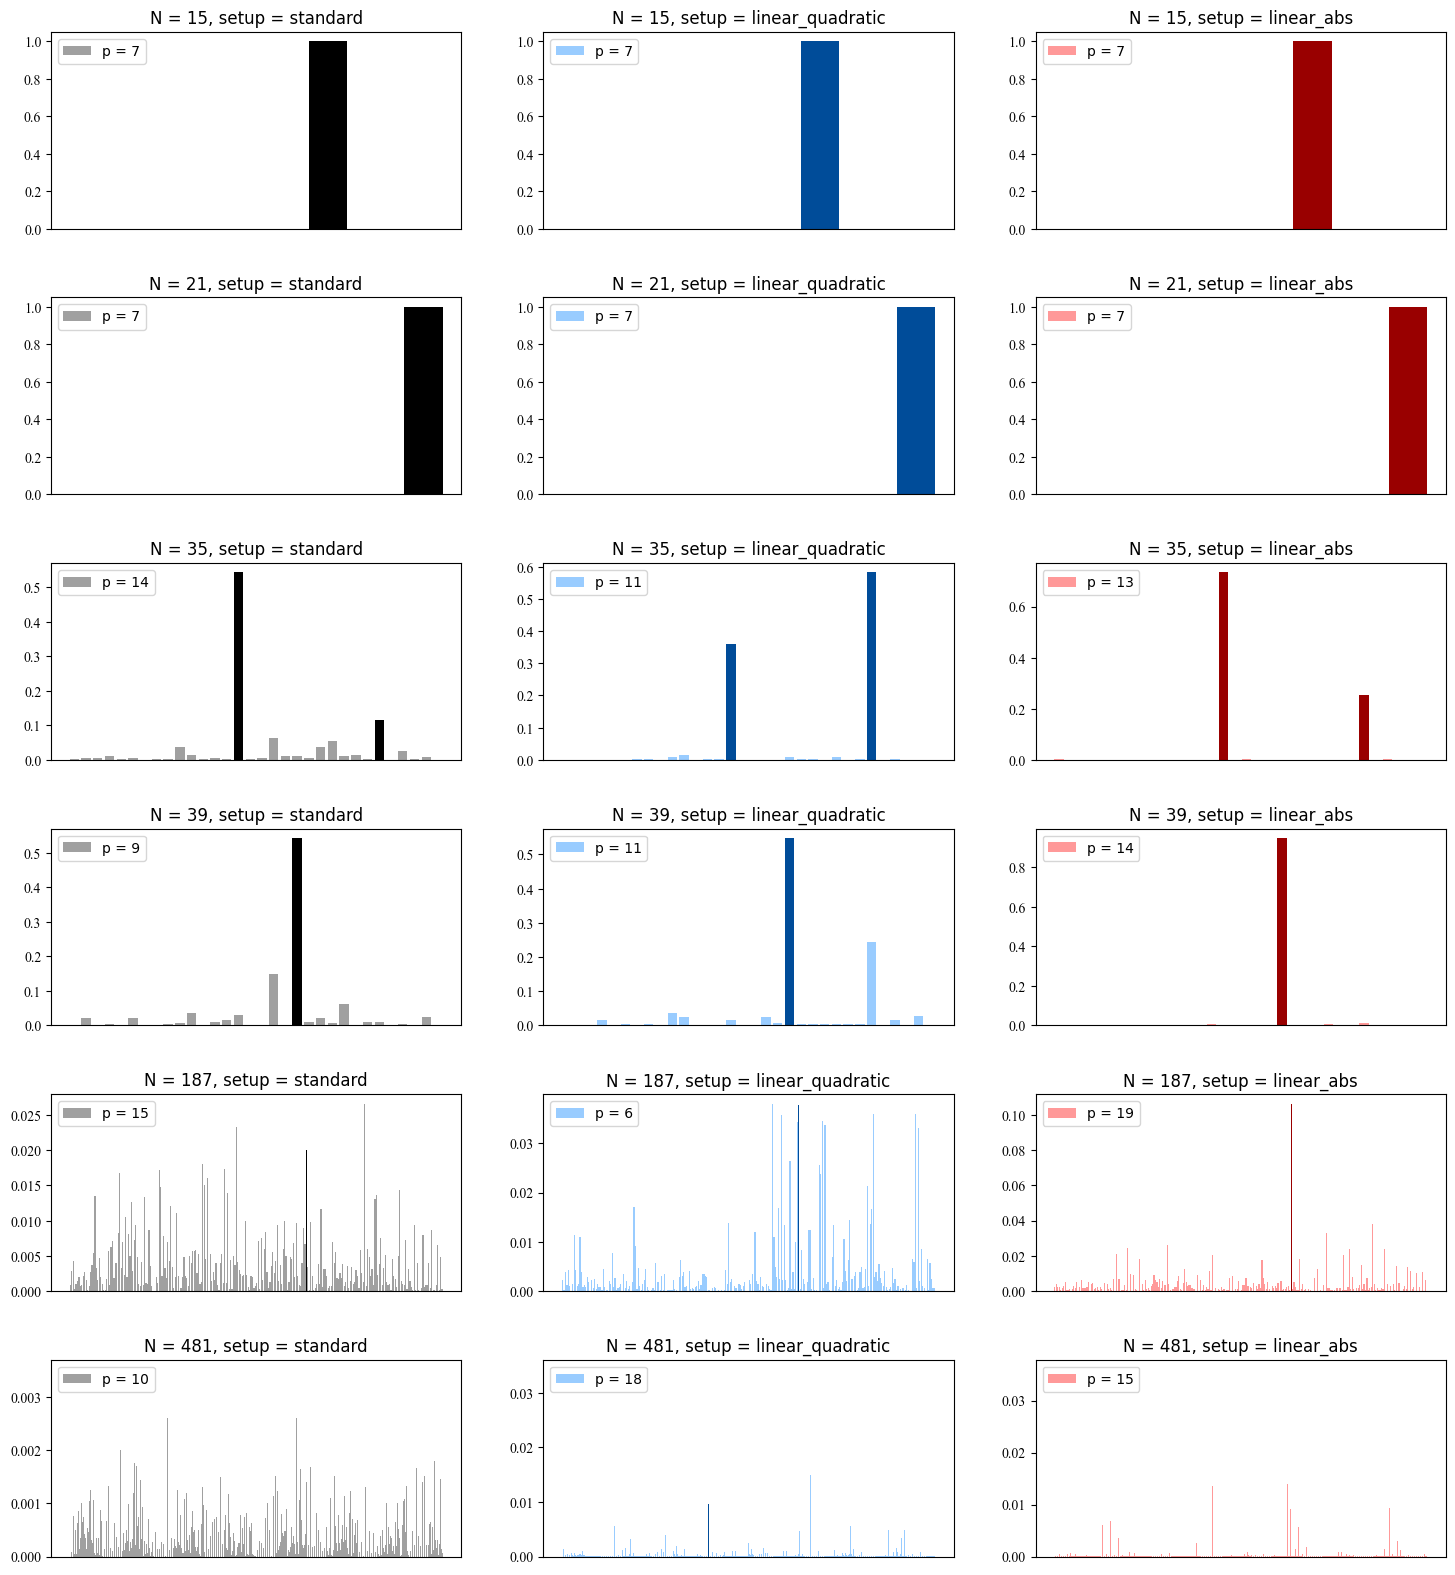

In [15]:
Ns = sorted(best_results.N.unique())
setups = sorted(best_results.setup.unique(), reverse=True)

fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = best_results[(best_results.N == N)].reset_index(drop=True)
    num_qubits = df_N.loc[0, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    for j, setup in enumerate(setups):
        df_N_setup = df_N[(df_N['setup']==setup)].reset_index(drop=True)
        layers = df_N_setup.loc[0, 'layers']
        df =  df_N_setup.loc[0, 'state_populations']

        bar_colors = [plot_colors[j][0] if c in solutions else plot_colors[j][1] for c in x_hist]

        axs[i][j].bar(x_hist, df, label=f'p = {layers}', color=bar_colors)
        axs[i][j].set_ylim(0)

        labels = (axs[i][j].get_xticklabels() + axs[i][j].get_yticklabels())

        for label in labels:
            label.set_fontname('Times New Roman')

        axs[i][j].legend(loc='upper left')
        axs[i][j].set_xticks(range(2**num_qubits), "")
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].set_title(f'N = {N}, setup = {setup}')

## Cost-Fidelity correlations

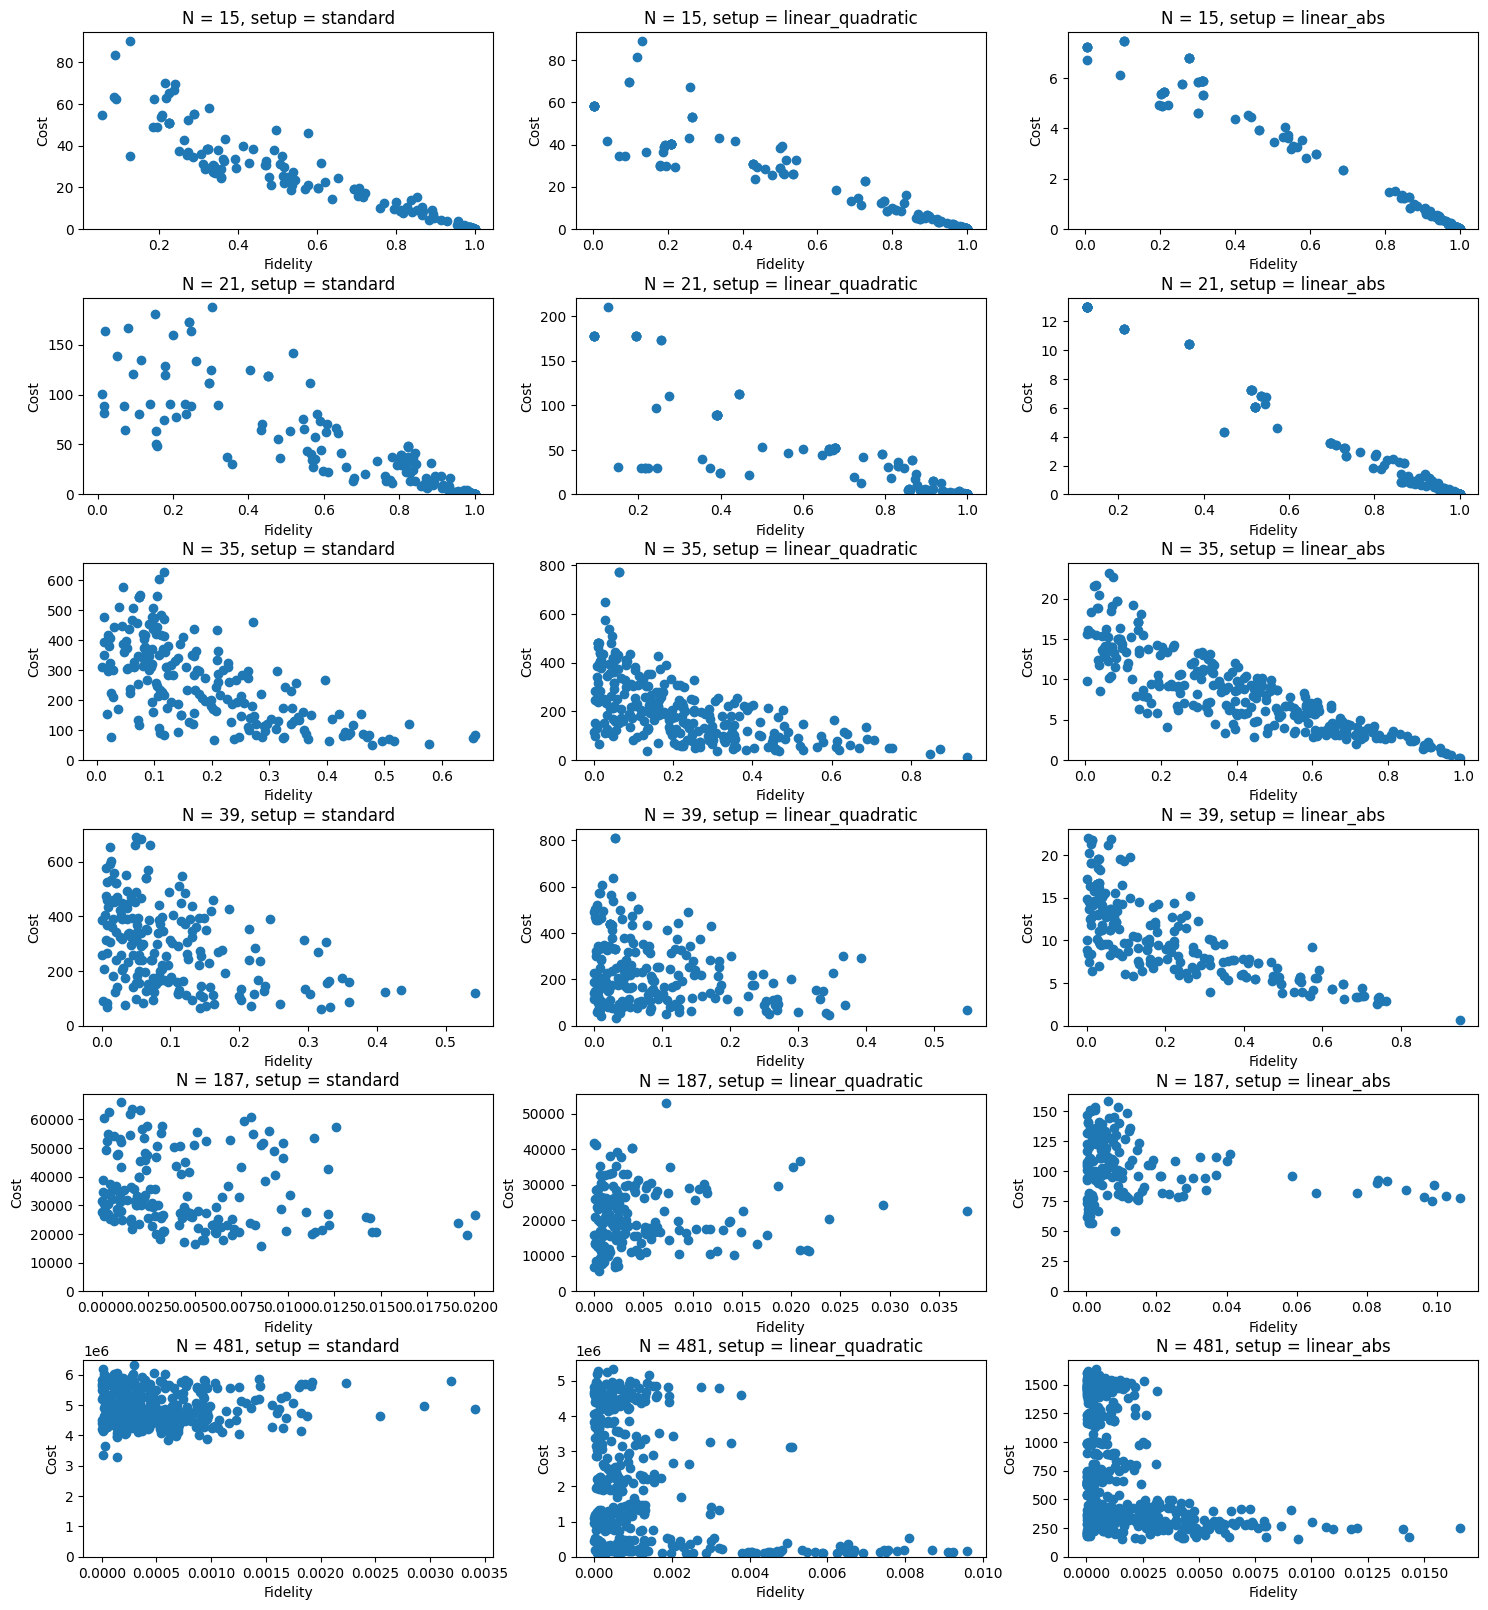

In [16]:
Ns = sorted(experiment_results.N.unique())
setups = sorted(experiment_results.setup.unique(), reverse=True)

fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results[(experiment_results.N == N) & (experiment_results['extended_qaoa']==False)].reset_index(drop=True)
    num_qubits = df_N.loc[0, 'num_qubits']

    for j, setup in enumerate(setups):
        df_N_setup = df_N[(df_N['setup']==setup)].reset_index(drop=True)

        scatter_colors = [plot_colors[j][0] if c in solutions else plot_colors[j][1] for c in x_hist]

        axs[i][j].scatter(df_N_setup['fidelity'], df_N_setup['cost'])
        axs[i][j].set_ylim(0)

        axs[i][j].set_title(f'N = {N}, setup = {setup}')
        axs[i][j].set_ylabel('Cost')
        axs[i][j].set_xlabel('Fidelity')

## Probability distributions

In [95]:
Ns = sorted(experiment_results['N'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []

for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = [E.real for E in solver.Ec]
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)

energies_df = pd.concat(dfs, ignore_index=True)

### abs_H

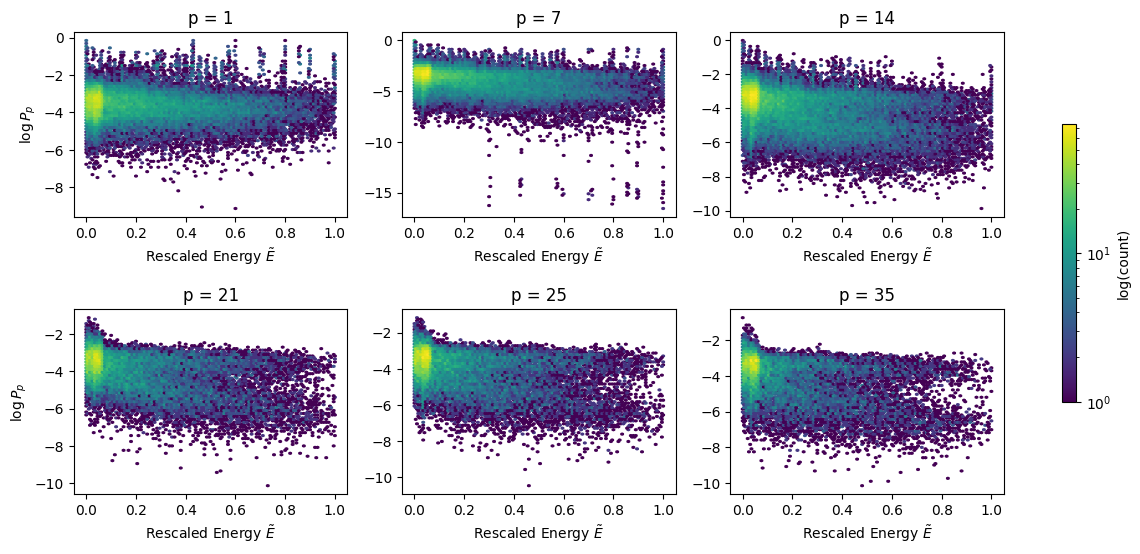

In [103]:
target_layers = [1, 7, 14, 21, 25, 35]

df = experiment_results.merge(energies_df, how='left', on=['N', 'cost_hamiltonian'])
df = df[df['layers'].isin(target_layers)].copy()
df = df.sort_values(by='layers')

df = df[df['cost_hamiltonian']=='abs_H']

ncols = 3
nrows = int(np.ceil(len(target_layers) / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
fig.subplots_adjust(hspace=0.5)
axs = axs.flatten()

for idx, p in enumerate(target_layers):
    ax = axs[idx]
    group = df[df['layers'] == p]

    rescaled_energies_all = []
    probs_all = []

    for _, row in group.iterrows():
        probs = np.log10(row['state_populations'])
        energies = np.array(row['Ec'])

        E_min = np.min(energies)
        E_max = np.max(energies)
        rescaled_E = (energies - E_min) / (E_max - E_min)

        rescaled_energies_all.extend(rescaled_E)
        probs_all.extend(probs)

    # Plot using hexbin for density
    hb = ax.hexbin(rescaled_energies_all, probs_all, cmap='viridis', bins='log')
    ax.set_title(f'p = {p}')
    ax.set_xlabel('Rescaled Energy $\\tilde{E}$')
    if idx % ncols == 0:
        ax.set_ylabel('$\\log P_p$')

# Color bar for density
fig.colorbar(hb, ax=axs.tolist(), label='log(count)', shrink=0.6)

# Hide unused subplots
for j in range(idx + 1, len(axs)):
    fig.delaxes(axs[j])

plt.show()

### quadratic_H

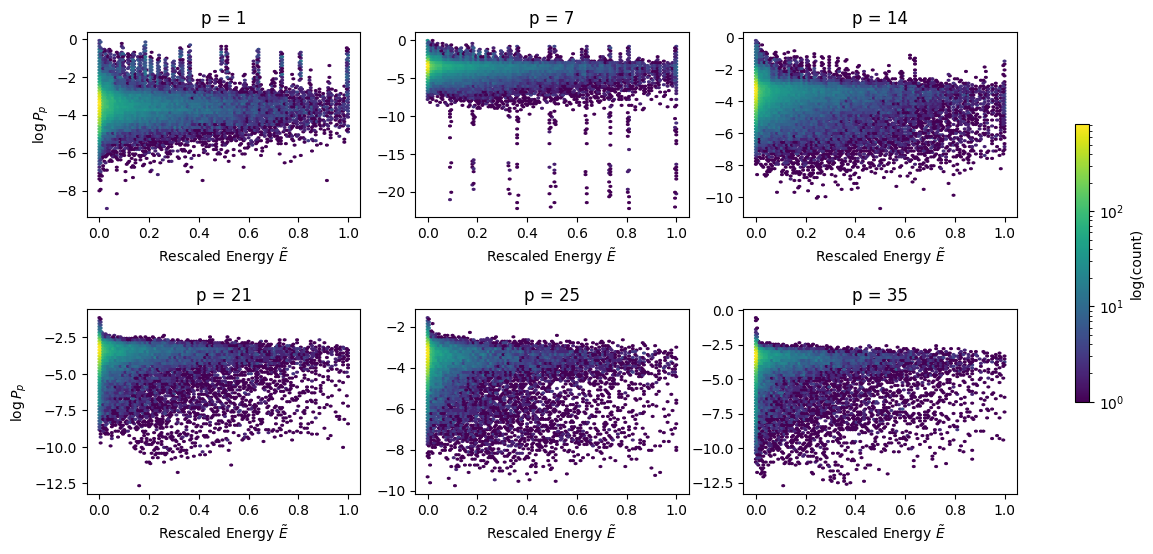

In [104]:
target_layers = [1, 7, 14, 21, 25, 35]

df = experiment_results.merge(energies_df, how='left', on=['N', 'cost_hamiltonian'])
df = df[df['layers'].isin(target_layers)].copy()
df = df.sort_values(by='layers')

df = df[df['cost_hamiltonian']=='quadratic_H']

ncols = 3
nrows = int(np.ceil(len(target_layers) / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
fig.subplots_adjust(hspace=0.5)
axs = axs.flatten()

for idx, p in enumerate(target_layers):
    ax = axs[idx]
    group = df[df['layers'] == p]

    rescaled_energies_all = []
    probs_all = []

    for _, row in group.iterrows():
        probs = np.log10(row['state_populations'])
        energies = np.array(row['Ec'])

        E_min = np.min(energies)
        E_max = np.max(energies)
        rescaled_E = (energies - E_min) / (E_max - E_min)

        rescaled_energies_all.extend(rescaled_E)
        probs_all.extend(probs)

    # Plot using hexbin for density
    hb = ax.hexbin(rescaled_energies_all, probs_all, cmap='viridis', bins='log')
    ax.set_title(f'p = {p}')
    ax.set_xlabel('Rescaled Energy $\\tilde{E}$')
    if idx % ncols == 0:
        ax.set_ylabel('$\\log P_p$')

# Color bar for density
fig.colorbar(hb, ax=axs.tolist(), label='log(count)', shrink=0.6)

# Hide unused subplots
for j in range(idx + 1, len(axs)):
    fig.delaxes(axs[j])

plt.show()